In [1]:
import numpy as np
import pandas as pd

import os
import sys
import json
from pathlib import Path
import gc
import inspect
import random
import time

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pathlib import Path

from copy import deepcopy
from copy import copy

from tqdm.notebook import tqdm

from multiprocess import Pool

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
import torch

In [3]:
sys.path.insert(0, '../DSL')
import solvers
import verifiers
import verifiers_reformatted
from dsl_format_checker import *
from solver_class import Solver
import dsl
from dsl import *
from constants import *

sys.path.insert(0, '..')
from visualization.visualization_utils import *
from misc_utils import *

In [4]:
data_path = Path('../data')
train_path = data_path / 'arc-agi_training_challenges.json'
train_sols_path = data_path / 'arc-agi_training_solutions.json'
eval_path = data_path / 'arc-agi_evaluation_challenges.json'
eval_sols_path = data_path / 'arc-agi_evaluation_solutions.json'

In [5]:
with open(train_path, 'r') as f:
    train_tasks = json.load(f)
with open(train_sols_path, 'r') as f:
    train_sols = json.load(f)
with open(eval_path, 'r') as f:
    eval_tasks = json.load(f)
with open(eval_sols_path, 'r') as f:
    eval_sols = json.load(f)

train_task_labels = sorted(train_tasks.keys())
eval_task_labels = sorted(eval_tasks.keys())

In [6]:
ast = lambda g: tuple(tuple(r) for r in g) # Converts grid to tuple format for DSL

# Convert all train and eval examples to tuples for DSL
for train_label in train_task_labels:
    num_train = len(train_tasks[train_label]['train']) 
    num_test = len(train_tasks[train_label]['test'])
    for i in range(num_train):
        train_tasks[train_label]['train'][i]['input'] = ast(train_tasks[train_label]['train'][i]['input'])
        train_tasks[train_label]['train'][i]['output'] = ast(train_tasks[train_label]['train'][i]['output'])
    for i in range(num_test):
        train_tasks[train_label]['test'][i]['input'] = ast(train_tasks[train_label]['test'][i]['input'])
        train_sols[train_label][i] = ast(train_sols[train_label][i])
for eval_label in eval_task_labels:
    num_train = len(eval_tasks[eval_label]['train']) 
    num_test = len(eval_tasks[eval_label]['test'])
    for i in range(num_train):
        eval_tasks[eval_label]['train'][i]['input'] = ast(eval_tasks[eval_label]['train'][i]['input'])
        eval_tasks[eval_label]['train'][i]['output'] = ast(eval_tasks[eval_label]['train'][i]['output'])
    for i in range(num_test):
        eval_tasks[eval_label]['test'][i]['input'] = ast(eval_tasks[eval_label]['test'][i]['input'])
        eval_sols[eval_label][i] = ast(eval_sols[eval_label][i])

In [7]:
SOLVERS = [Solver(inspect.getsource(getattr(solvers, f"solve_{label}"))) for label in train_task_labels]
VERIFIERS = [Solver(inspect.getsource(getattr(verifiers, f"verify_{label}"))) for label in train_task_labels]
for S in SOLVERS + VERIFIERS:
    S.rename("solve")
DSL_FUNCS = set(SOLVERS + VERIFIERS)

In [8]:
IN_GRIDS = set()
OUT_GRIDS = set()

for task in train_tasks.values():
    for pair in task['train']:
        IN_GRIDS.add(pair['input'])
        OUT_GRIDS.add(pair['output'])
    for inp in task['test']:
        IN_GRIDS.add(inp['input'])

for tests in train_sols.values():
    for test in tests:
        OUT_GRIDS.add(test)

IN_GRIDS = list(IN_GRIDS)
OUT_GRIDS = list(OUT_GRIDS)
        
print(f"There are {len(IN_GRIDS)} input grids, and {len(OUT_GRIDS)} output grids")

There are 1712 input grids, and 1644 output grids


In [9]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {DEVICE}")

Using cuda


# Load pretrained model

In [10]:
codegen_tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-350M-mono",
                                                 padding_side='left', # For padding batches of input in decoder-only context
                                                 clean_up_tokenization_spaces = True,
                                                 ) 
codegen = AutoModelForCausalLM.from_pretrained("../CodeGen fine-tuning/outputs/v7/")
codegen = codegen.to(DEVICE)

In [11]:
EOS_TOKEN = codegen_tokenizer.eos_token
BOS_TOKEN = codegen_tokenizer.bos_token
PAD_TOKEN = '[PAD]'
codegen_tokenizer.add_special_tokens({'pad_token': PAD_TOKEN})

1

# Helper functions

In [12]:
def memory_safe_beam_generate(model,
                              tokenizer,
                              inputs,
                              generate_args = {
                                    'max_new_tokens': 256,
                                    'num_beams': 8,
                                    'num_return_sequences': 8,
                                },
                             ):
    tokens = [tokenizer(prompt, padding = True, return_tensors = 'pt').to(DEVICE) for prompt in inputs]
    results = []
    for t in tokens:
        outputs = []
        while len(outputs) == 0:
            try:
                outputs = model.generate(**t,
                         pad_token_id = tokenizer.pad_token_id,
                        **generate_args,
                        )
            except torch.cuda.OutOfMemoryError:
                generate_args['num_beams'] = generate_args['num_beams']//2
                generate_args['num_return_sequences'] = generate_args['num_return_sequences']//2
                if generate_args['num_beams'] == 0:
                    raise MemoryError('num_beams was reduced to 1, but still ran out of memory!')
        results.extend(tokenizer.batch_decode(outputs, skip_special_tokens = True))
    return results

In [20]:
def memory_safe_generate(model,
                         tokenizer,
                         inputs,
                         generate_args = {
                           'max_new_tokens': 512, 
                           'do_sample': True,
                           'temperature': 2.0,
                           'top_k': 50,
                         },
                         batchsize = 32,
                        ):
    current_idx = 0
    results = []
    while current_idx < len(inputs):
        outputs = None
        while outputs == None:
            tokens = tokenizer(inputs[current_idx : current_idx + batchsize],
                               padding = True,
                               return_tensors = 'pt',
                              ).to(DEVICE)
            try:
                outputs = model.generate(**tokens,
                                 pad_token_id = tokenizer.pad_token_id,
                                **generate_args,
                                )
            except torch.cuda.OutOfMemoryError:
                outputs = None
                batchsize = batchsize // 2
                if batchsize == 0:
                    raise MemoryError('batchsize was reduced to 1, but still ran out of memory!')

        results.extend(tokenizer.batch_decode(outputs, skip_special_tokens = True))
        current_idx += batchsize
        print(current_idx)
            
    return results

In [14]:
def clean_candidates(candidates: list[str]) -> [int, list[str]]:
    failed = []
    cleaned = []
    for candidate in candidates:
        if "return O" not in candidate:
            failed.append(candidate)
        else:
            cleaned.append(candidate.split("return O")[0] + "return O")
    return failed, cleaned            

In [15]:
def compile_candidates(candidates: list[str]) -> [int, list[Solver]]:
    failed = []
    compiled = []
    for candidate in candidates:
        try:
            compiled.append(Solver(candidate))
        except:
            failed.append(candidate)
    return failed, compiled

In [16]:
def remove_docstring(solver_text):
    S = solver_text.split('    """\n', 2)
    if len(S) == 1:
        return S[0]
    else:
        return S[0] + S[-1]

In [17]:
def is_valid_grid(G, enforce_30_x_30 = True, enforce_palette = False):
	"""
	Verify that a grid is indeed a tuple of tuples of ints from 0 to 9,
	with all rows having same length and dimensions at most 30 x 30.

	By default, enforce_palette is False to speed up runtime.
	"""

	# Verify G is a nonempty tuple
	if not isinstance(G, tuple):
		return False
	if len(G) == 0:
		return False

	# Verify rows are tuples containing ints 0 to 9
	for row in G:
		if not isinstance(row, tuple):
			return False

	# Check rows have same lengths
	if len(set([len(row) for row in G])) > 1:
		return False

	# Check grid is at most 30 x 30
	if enforce_30_x_30:
		if not len(G) <= 30:
			return False
		if not len(G[0]) <= 30:
			return False

	# Check entries are 0 to 9
	if enforce_palette:
		entries = set([a for a in row for row in G])
		if not len(entries.difference(set([0,1,2,3,4,5,6,7,8,9]))) == 0:
			return False

	return True


# Generate solvers

In [18]:
%env TOKENIZERS_PARALLELISM true

env: TOKENIZERS_PARALLELISM=true


In [19]:
NUM_TO_GENERATE = 2048
prompts = ["    " + "\n    ".join([row for row in grid_to_string_compact(random_grid(rows = 4, cols = 4)).split("\n")]) + '\n   """\n' for _ in range(NUM_TO_GENERATE)]

In [ ]:
candidates = memory_safe_beam_generate(codegen,
                                       codegen_tokenizer,
                                       prompts, 
                                       generate_args = {
                                            'max_new_tokens': 128,
                                            'num_beams': 64,
                                            'num_return_sequences': 64,
                                           #'do_sample': True,
                                           #'temperature': 4.0,
                                           #'force_words_ids': [[7783, 440]] # Encoding of 'return O'
                                        }
                                      )

In [ ]:
candidates = memory_safe_generate(codegen,
                                   codegen_tokenizer,
                                   prompts, 
                                   generate_args = {
                                        'max_new_tokens': 768,
                                       'do_sample': True,
                                       'temperature': 2.2,
                                       #'force_words_ids': [[7783, 440]] # Encoding of 'return O'
                                    }
                                      )

In [22]:
print(len(candidates))

2048


In [23]:
candidates = [c for c in candidates if 'return O' in c]
print(len(candidates))

1858


In [24]:
candidates = ['def solve(I):\n'+c.split('"""\n')[-1] for c in candidates]
candidates = list(set(candidates))
print(len(candidates))

1109


In [25]:
well_formed = []
for c in candidates:
    try:
        check_solver_formatting(c)
        well_formed.append(c)
    except AssertionError as exc:
        pass
print(len(well_formed))

347


In [26]:
compiled = []
for c in well_formed:
    try:
        compiled.append(Solver(c))
    except:
        pass
print(len(compiled))

326


In [27]:
compiled = list(set(compiled).difference(DSL_FUNCS))
print(len(compiled))

326


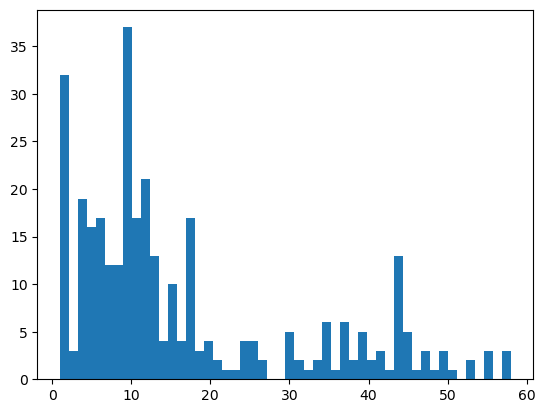

In [28]:
plt.hist([S.num_lines() for S in compiled], bins = 50)
plt.show()

In [29]:
rates = []
results = []
for S in tqdm(compiled):
    with Pool(12) as P:
        async_outs = [P.apply_async(lambda x: (x, S(x)), (grid,)) for grid in IN_GRIDS]
        pairs = []
        for R in async_outs:
            try:
                inp, out = R.get(0.05)
                assert is_valid_grid(out)
                assert out != inp
                assert len(set.union(*[set(row) for row in out])) > 1
                pairs.append({'input': inp, 'output': out})
            except:
                pass
        results.append(pairs)
        rates.append(len(pairs)/len(IN_GRIDS))
        

  0%|          | 0/326 [00:00<?, ?it/s]

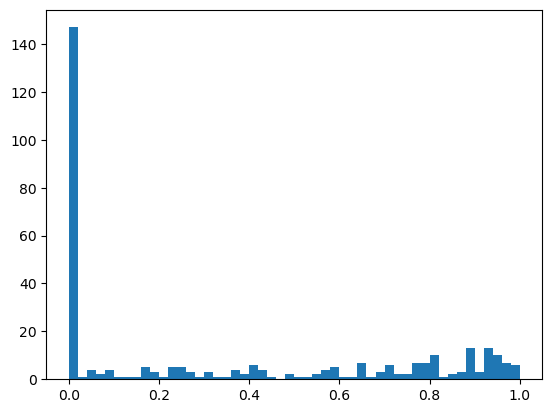

In [30]:
plt.hist(rates, bins = 50)
plt.show()

In [31]:
print(sum(rate > 0.5 for rate in rates))

118


In [32]:
new_examples = []
for i in range(len(compiled)):
    if rates[i] > 0.5:
        for pair in results[i]:
            compiled[i].update_docstring(create_docstring(*pair.values()))
            new_examples.append(str(compiled[i]))

In [33]:
with open("augment.py", "w") as f:
    f.write("\n\n\n".join(ex for ex in new_examples))

# Scratch work

In [19]:
pd.Series(beam_log).value_counts()

16    1348
64       9
32       6
Name: count, dtype: int64

NOTES:
 * Using top_p = 0.9, temp = 1.5 instead of top_k narrows results down to things that actually compile and speeds up computation. Generally top_p seems better than top_k.

In [21]:
test_label = '48f8583b'
label = test_label
print(label)

48f8583b


In [22]:
pairs = eval_tasks[label]['train']

In [227]:
torch.cuda.empty_cache()

In [217]:
NEW_SOLVERS_COUNT = 0

In [218]:
prompts = create_prompts_from_pairs(pairs, len(pairs))

In [219]:
len(prompts)

6

In [220]:
tokens = [codegen_tokenizer(prompt, padding = True, return_tensors = 'pt').to(DEVICE) for prompt in prompts]

In [221]:
# 27 seconds with 32 beams and 768 new tokens, no OOM
# 15 seconds with 32 beams and 512 new tokens, no OOM
# 192 seconds with 32 beams and 512 new tokens and low_memory = True
# 
# Weirdly, temp 5.0 resulted in more compiled solvers and lower scores...

In [237]:
configs = [(32, 512), (64, 256), (16, 1024)]
full_results = {}

for NUM_BEAMS, MAX_NEW_TOKENS in tqdm(configs):
    generate_args = {
        'max_new_tokens': MAX_NEW_TOKENS,
        'num_beams': NUM_BEAMS,
        'num_return_sequences': NUM_BEAMS,
        'do_sample': True,
        'temperature': 2.0,
        #'low_memory': True # WAY TOO SLOW
    }
    results = []
    candidates = []
    for t in tokens:
        outputs = []
        try:
            outputs = codegen.generate(**t,
                     pad_token_id = codegen_tokenizer.pad_token_id,
                    **generate_args,
                    )
        except torch.cuda.OutOfMemoryError:
            print("OOM")
        candidates.extend(codegen_tokenizer.batch_decode(outputs, skip_special_tokens = True))

    failed, cleaned = clean_candidates(candidates)
    results.extend([(1.1, F) for F in failed])

    failed, compiled = compile_candidates(cleaned)
    results.extend([(1.1, F) for F in failed])

    scored = score_solvers_vs_tasks(compiled, pairs, scoring_functions, solver_timeout = 1.0)
    results.extend(scored)

    full_results[(NUM_BEAMS, MAX_NEW_TOKENS)] = sorted(results, key = lambda x: x[0])    


  0%|          | 0/3 [00:00<?, ?it/s]

In [238]:
for key, results in full_results.items():
    print(key)
    print(results[0][0], results[0][1])
    print("")

(32, 512)
0.276010101010101 def solve(I):
    """
    INPUT:
    717
    177
    717
    OUTPUT:
    000717000
    000177000
    000717000
    717000000
    177000000
    717000000
    000717000
    000177000
    000717000
    """
    x1 = ofcolor(I, ONE)
    x2 = shape(I)
    x3 = multiply(x2, x2)
    x4 = canvas(ZERO, x3)
    x5 = rbind(multiply, x2)
    x6 = apply(x5, x1)
    x7 = asobject(I)
    x8 = lbind(shift, x7)
    x9 = mapply(x8, x6)
    O = paint(x4, x9)
    return O

(64, 256)
0.0 def solve(I):
    """
    INPUT:
    717
    177
    717
    OUTPUT:
    000717000
    000177000
    000717000
    717000000
    177000000
    717000000
    000717000
    000177000
    000717000
    """
    x1 = leastcolor(I)
    x2 = ofcolor(I, x1)
    x3 = shape(I)
    x4 = multiply(x3, x3)
    x5 = canvas(ZERO, x4)
    x6 = rbind(multiply, x3)
    x7 = apply(x6, x2)
    x8 = asobject(I)
    x9 = lbind(shift, x8)
    x10 = mapply(x9, x7)
    O = paint(x5, x10)
    return O

(16, 1024)
0.3610256

<code>generate_args = {
        'max_new_tokens': MAX_NEW_TOKENS,
        'num_beams': NUM_BEAMS,
        'num_return_sequences': NUM_BEAMS,
        #'do_sample': True,
        #'temperature': 3.0,
        #'low_memory': True # WAY TOO SLOW
    }

In [236]:
for key, results in full_results.items():
    print(key)
    print(results[0][0], results[0][1])
    print("")

(32, 512)
0.276010101010101 def solve(I):
    """
    INPUT:
    717
    177
    717
    OUTPUT:
    000717000
    000177000
    000717000
    717000000
    177000000
    717000000
    000717000
    000177000
    000717000
    """
    x1 = ofcolor(I, ONE)
    x2 = shape(I)
    x3 = multiply(x2, x2)
    x4 = canvas(ZERO, x3)
    x5 = rbind(multiply, x2)
    x6 = apply(x5, x1)
    x7 = asobject(I)
    x8 = lbind(shift, x7)
    x9 = mapply(x8, x6)
    O = paint(x4, x9)
    return O

(64, 256)
0.0 def solve(I):
    """
    INPUT:
    717
    177
    717
    OUTPUT:
    000717000
    000177000
    000717000
    717000000
    177000000
    717000000
    000717000
    000177000
    000717000
    """
    x1 = leastcolor(I)
    x2 = ofcolor(I, x1)
    x3 = shape(I)
    x4 = multiply(x3, x3)
    x5 = canvas(ZERO, x4)
    x6 = rbind(multiply, x3)
    x7 = apply(x6, x2)
    x8 = asobject(I)
    x9 = lbind(shift, x8)
    x10 = mapply(x9, x7)
    O = paint(x5, x10)
    return O

(16, 1024)
0.3610256

In [222]:
start = time.time()
try:
    outputs = codegen.generate(**tokens[0],
                     pad_token_id = codegen_tokenizer.pad_token_id,
                    **generate_args,
                    )
except torch.cuda.OutOfMemoryError:
    print("OOM")
print(f"{time.time()-start:.2f} seconds")

10.32 seconds


In [223]:
candidates = codegen_tokenizer.batch_decode(outputs, skip_special_tokens = True)
print(len(candidates))

64


In [224]:
failed1, cleaned = clean_candidates(candidates)
print(len(cleaned))

35


In [225]:
failed2, compiled = compile_candidates(cleaned)
print(len(compiled))

35


In [226]:
scored = score_solvers_vs_tasks(compiled, pairs, scoring_functions, solver_timeout = 1.0)
scored = sorted(scored, key = lambda x: x[0])
print(sum([score < 1.0 for score, _ in scored]))
print([score for score, _ in scored])

16
[0.3239538982502369, 0.3391996891996892, 0.361025641025641, 0.361025641025641, 0.4003108003108003, 0.4186868686868687, 0.4585714285714286, 0.4593245640097597, 0.46058648192693497, 0.4626586983363246, 0.480519978106185, 0.480519978106185, 0.4814417895672325, 0.5378794364187622, 0.6142857142857142, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [147]:
print(scored[0][0], scored[0][1])

0.361025641025641 def solve(I):
    """
    INPUT:
    996
    388
    833
    OUTPUT:
    000000996
    000000388
    000000833
    000000000
    000000000
    000000000
    000000000
    000000000
    000000000
    """
    x1 = shape(I)
    x2 = multiply(x1, x1)
    x3 = canvas(ZERO, x2)
    x4 = mostcolor(I)
    x5 = ofcolor(I, x4)
    x6 = lbind(multiply, x1)
    x7 = apply(x6, x5)
    x8 = asobject(I)
    x9 = lbind(shift, x8)
    x10 = mapply(x9, x7)
    O = paint(x3, x10)
    return O
